# Определение стоимости автомобилей

## Импорт библиотек и выгрузка данных

Выгрузим все необходимые для работы библиотеки

In [37]:
!pip install catboost --quiet

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb
from catboost import CatBoostRegressor
#Randomforest
RANDOM_STATE=12345

Выгрузим данные

In [39]:
df = pd.read_csv('autos.csv')

## Подготовка и анализ данных

Рассмотрим общую информацию о данных

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [41]:
df.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


In [42]:
df.describe(include=np.object_).T

,count,unique,top,freq
DateCrawled,354369,271174,2016-03-24 14:49:47,7
VehicleType,316879,8,sedan,91457
Gearbox,334536,2,manual,268251
Model,334664,250,golf,29232
FuelType,321474,7,petrol,216352
Brand,354369,40,volkswagen,77013
Repaired,283215,2,no,247161
DateCreated,354369,109,2016-04-03 00:00:00,13719
LastSeen,354369,179150,2016-04-06 13:45:54,17


**Промежуточный вывод**

После просмотра общей информации можно сделать несколько наблюдений:
– Стоит проверить данные на дубликаты
– Стоит проверить количественные данные на выбросы и аномальные значения
– Столбцы, отражающие временные данные, стоит перевести в тип данных datetime;
– Видно, что пропуски имеются только в столбцах с категориальными данными;
– В данных есть столбец, содержащий только нули. Целевой ценности он нести не будет, поэтому его следует удалить;

## Предобработка

### Проверка на дубликаты

Проверим данные на дубликаты

In [43]:
df[df.duplicated()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


Определили 4 строки, удалим их

In [44]:
df = df.drop_duplicates()

## Анализ выбросов

Проверим столбцы с количественными данными на выбросы

In [45]:
df.describe(include=np.number).T

,count,mean,std,min,25%,50%,75%,max
Price,354365.0,4416.679830,4514.176349,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354365.0,2004.234481,90.228466,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354365.0,110.093816,189.851330,0.0,69.0,105.0,143.0,20000.0
Kilometer,354365.0,128211.363989,37905.083858,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354365.0,5.714650,3.726432,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354365.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354365.0,50508.503800,25783.100078,1067.0,30165.0,49413.0,71083.0,99998.0


Напишем функцию для графического анализа

In [46]:
def dsc(column):

    plt.figure(figsize=(7,3))
    sns.histplot(data=df, x=column, kde=True, bins=20)
    plt.show()
    plt.figure(figsize=(8,3))
    sns.boxplot(data=df, x=column)
    plt.show()

#### Price

Рассмотрим столбец поподробнее

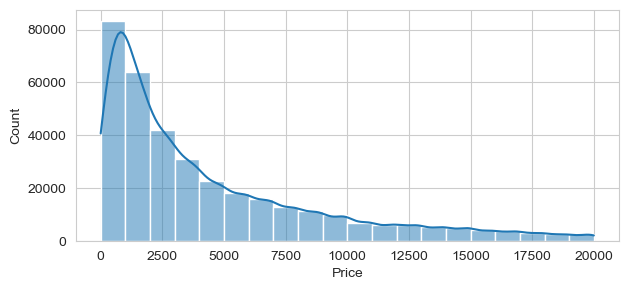

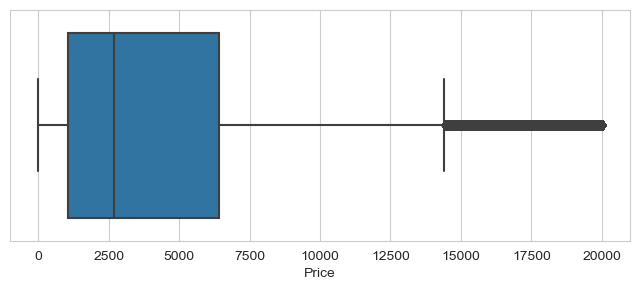

In [47]:
dsc('Price')

Пропусков не обнаружено, видны выбросы при нулевой стоимости. Удалим их

In [48]:
df = df.query('Price > 0')

#### RegistrationYear

Рассмотрим столбец подробнее

In [49]:
df['RegistrationYear'].describe()

count    343593.00000
mean       2004.08983
std          78.41368
min        1000.00000
25%        1999.00000
50%        2003.00000
75%        2008.00000
max        9999.00000
Name: RegistrationYear, dtype: float64

Выделим наиболее адекватные годы регистрации машины: ближайшие 50 лет, то есть от 1966 до 2016 (так как данные собирались в 2016, годы регистрации позднее можно считать аномалиями

In [50]:
df = df.query('1966 <= RegistrationYear <= 2016')

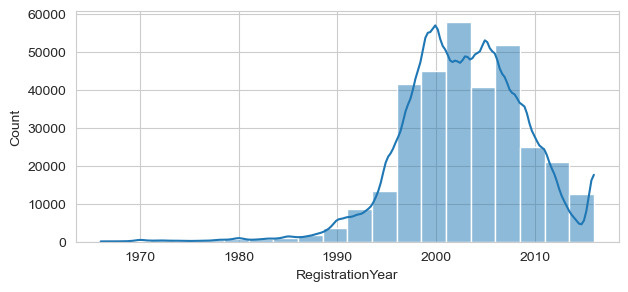

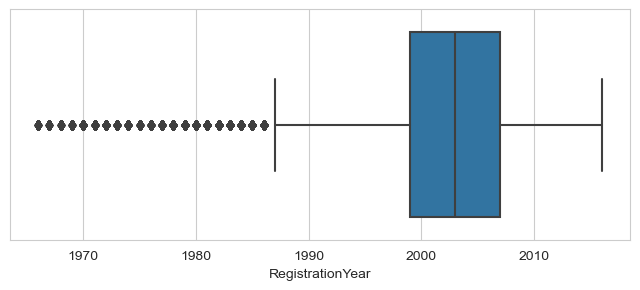

In [51]:
dsc('RegistrationYear')

Теперь данные выглядят более нормально

#### Power

Рассмотрим столбец подробнее

In [52]:
df['Power'].describe()

count    329065.000000
mean        112.036619
std         184.967906
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

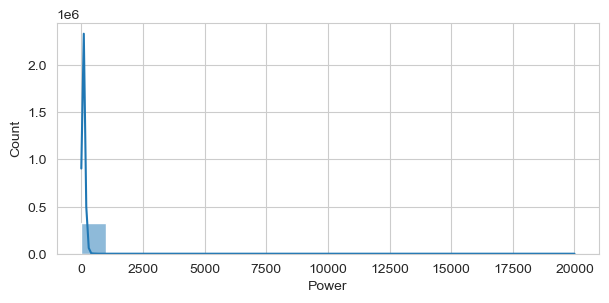

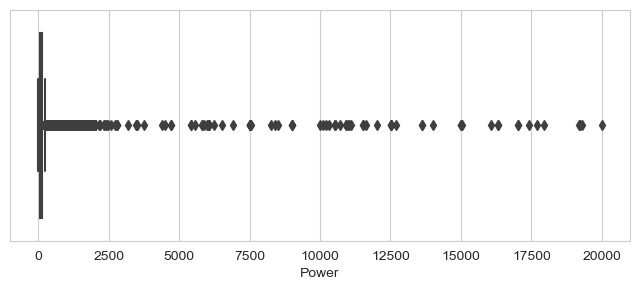

In [53]:
dsc('Power')

По гистограмме видно, что в данных имеются мощности до 20000 лошадиных сил с одной стороны, и нулевые значения с другой. Предлагается ограничиться данными от 35 до 1000 лошадиных сил

In [54]:
df = df.query('35 <= Power <= 1000')

#### Kilometer

Рассмотрим столбец подробнее

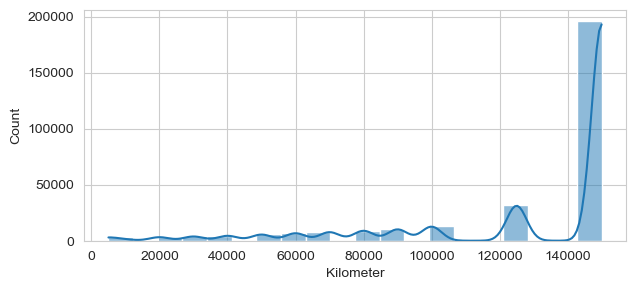

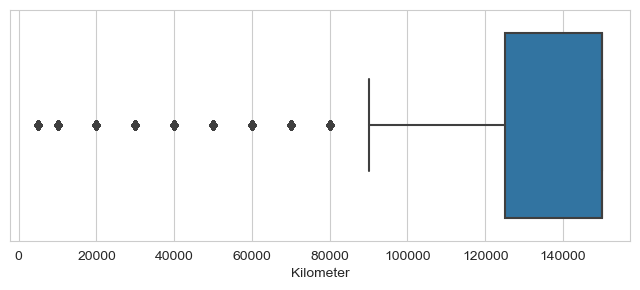

In [55]:
dsc('Kilometer')

Видно по графикам, что распределение вполне реалистично, аномально высоких пробегов нет.

#### RegistrationMonth

Рассмотрим столбец подробнее

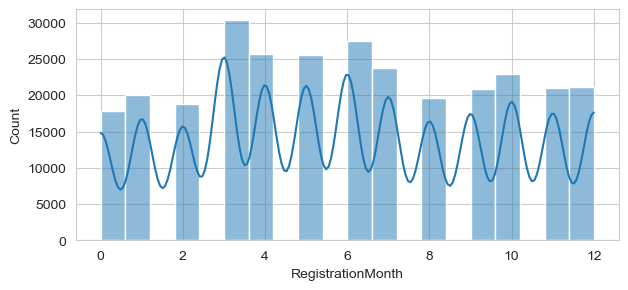

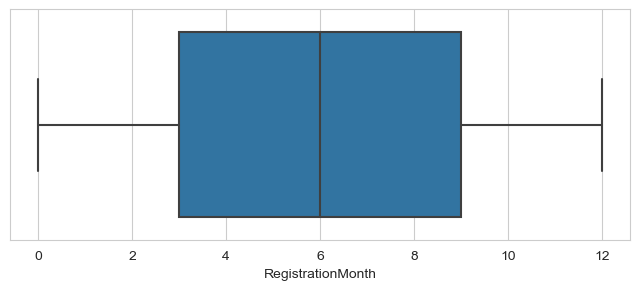

In [56]:
dsc('RegistrationMonth')

In [57]:
df[['Price','RegistrationMonth','RegistrationYear']].corr()

,Price,RegistrationMonth,RegistrationYear
Price,1.000000,0.069424,0.513003
RegistrationMonth,0.069424,1.000000,0.043678
RegistrationYear,0.513003,0.043678,1.000000


В данном столбце имеется аномальный "Нулевой месяц". Скорее всего, этот столбец будем удалять, так как месяц регистрации не играет никакого значения, по сравнению и годом регистрации. Поэтому нулевые значения оставим так. Создадим список со столбцами, подлежащими удалению

In [58]:
cols_to_del = []
cols_to_del.append('RegistrationMonth')

#### NumberOfPictures

Рассмотрим столбец подробнее

In [59]:
df['NumberOfPictures'].describe()

count    295254.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: NumberOfPictures, dtype: float64

Столбец состоит из нулей. Он подлежит удалению

In [60]:
cols_to_del.append('NumberOfPictures')

#### PostalCode

Рассмотрим корреляцию столбца с почтовыми индексами относительно цены машины

In [61]:
df[['Price','PostalCode']].corr()

,Price,PostalCode
Price,1.000000,0.063928
PostalCode,0.063928,1.000000


Почтовые индексы владельца анкеты никак не относится к стоимости авто, поэтому столбец подлежит удалению

In [62]:
cols_to_del.append('PostalCode')

## Удаление лишних данных

Выделим временные данные для удаления

In [63]:
for col in df.columns:
    res = re.match(r'[0-9]{4}-(0[1-9]|1[012])-(0[1-9]|1[0-9]|2[0-9]|3[01]) (0[0-9]|1[0-9]|2[123]):(0[0-9]|1[0-9]|2[0-9]|3[0-9]|4[0-9]|5[0-9]):(0[0-9]|1[0-9]|2[0-9]|3[0-9]|4[0-9]|5[0-9])', str(df.loc[1,col]))
    if res != None:
        cols_to_del.append(col)

## Заполнение пропусков

Заполним все пропуски в данных "заглушкой" unknown

In [64]:
df = df.fillna('unknown')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 295254 entries, 1 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        295254 non-null  object
 1   Price              295254 non-null  int64 
 2   VehicleType        295254 non-null  object
 3   RegistrationYear   295254 non-null  int64 
 4   Gearbox            295254 non-null  object
 5   Power              295254 non-null  int64 
 6   Model              295254 non-null  object
 7   Kilometer          295254 non-null  int64 
 8   RegistrationMonth  295254 non-null  int64 
 9   FuelType           295254 non-null  object
 10  Brand              295254 non-null  object
 11  Repaired           295254 non-null  object
 12  DateCreated        295254 non-null  object
 13  NumberOfPictures   295254 non-null  int64 
 14  PostalCode         295254 non-null  int64 
 15  LastSeen           295254 non-null  object
dtypes: int64(7), object(

## Подготовка признаков к обучению

Удалим лишние признаки

In [65]:
df = df.drop(cols_to_del, axis=1)

Выделим обучающую и тестовую выборки

In [66]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Price', axis=1),
                                                    df['Price'], test_size=.25,
                                                    random_state=RANDOM_STATE
                                                    )

## Обучение моделей

### LightGBM

Перед обучением отметим категориальные признаки в столбцах

In [67]:
X_train_lgb = X_train.copy()
X_test_lgb = X_test.copy()
for col in X_train.select_dtypes(include=['object_']).columns:
    X_train_lgb[col] = X_train_lgb[col].astype('category')
    X_test_lgb[col] = X_test_lgb[col].astype('category')

Обучим модель и измерим ее скорость обучения. За метрику возьмем требуюмую – RMSE:

In [68]:
params_lgb = {
    'learning_rate': [0.1,0.11,0.12,0.13,0.14,0.15],
    'n_estimators': range(50,401,50)
}

lgbst = lgb.LGBMRegressor(objective='regression', random_state=RANDOM_STATE)


model_lgb = GridSearchCV(estimator=lgbst,
                         param_grid=params_lgb,
                         cv=3,
                         n_jobs=-1,
                         scoring='neg_root_mean_squared_error',
                         )
s = time.time()
model_lgb.fit(X_train_lgb, y_train)
e = time.time()
print('LGBMRegressor:')
print(f'Лучшие параметры: {model_lgb.best_params_}')
print(f'Скорость обучения: {round(e-s,2)}')
print(f'RMSE для лучших параметров:', round(model_lgb.best_score_*(-1), 0))
s = time.time()
pred = model_lgb.predict(X_train_lgb)
e = time.time()
print(f'Скорость предсказания модели: {round(e-s,2)}')

LGBMRegressor:
Лучшие параметры: {'learning_rate': 0.15, 'n_estimators': 400}
Скорость обучения: 52.68
RMSE для лучших параметров: 1543.0
Скорость предсказания модели: 0.59


### Catboost

Обучим модель:

In [69]:
cat_features = X_train.select_dtypes(include=['object_']).columns.tolist()
params_cat = {
    'depth': [5, 6, 7, 8, 9, 10],
    'learning_rate': [0.1, 0.11,0.12,0.13,0.14,0.15],
}

# Инициализируем CatBoostRegressor estimattor
catboost = CatBoostRegressor(loss_function="RMSE", iterations=100, random_state=RANDOM_STATE)

# Инициализируем Grid Search
model_cat_boost = GridSearchCV(estimator=catboost,
                               param_grid=params_cat,
                               cv=3,
                               n_jobs=-1,
                               scoring='neg_root_mean_squared_error',
                               )
s = time.time()
model_cat_boost.fit(X_train,
                    y_train,
                    cat_features=X_train.select_dtypes(include=['object_']).columns.tolist()
                    )
e = time.time()

print('CatBoostRegressor:')
print(f'Лучшие параметры: {model_cat_boost.best_params_}')
print(f'Скорость обучения: {round(e-s,2)}')
print(f'RMSE для лучших параметров:', round(model_cat_boost.best_score_*(-1), 2))
s = time.time()
pred = model_cat_boost.predict(X_train)
e = time.time()
print(f'Скорость предсказания модели: {round(e-s,2)}')

0:	learn: 4318.4028065	total: 161ms	remaining: 15.9s
1:	learn: 4062.5293570	total: 225ms	remaining: 11s
2:	learn: 3834.6533250	total: 320ms	remaining: 10.4s
3:	learn: 3633.7738881	total: 396ms	remaining: 9.51s
4:	learn: 3455.5722819	total: 464ms	remaining: 8.81s
5:	learn: 3297.7010861	total: 547ms	remaining: 8.57s
6:	learn: 3157.7115209	total: 623ms	remaining: 8.28s
7:	learn: 3032.2240829	total: 676ms	remaining: 7.78s
8:	learn: 2925.6396783	total: 746ms	remaining: 7.54s
9:	learn: 2826.4590271	total: 817ms	remaining: 7.35s
10:	learn: 2739.5074544	total: 872ms	remaining: 7.05s
11:	learn: 2655.2377339	total: 939ms	remaining: 6.88s
12:	learn: 2584.4590927	total: 981ms	remaining: 6.56s
13:	learn: 2521.0823293	total: 1.05s	remaining: 6.48s
14:	learn: 2465.7817138	total: 1.11s	remaining: 6.29s
15:	learn: 2419.1505788	total: 1.17s	remaining: 6.15s
16:	learn: 2376.3843921	total: 1.24s	remaining: 6.03s
17:	learn: 2336.4166534	total: 1.31s	remaining: 5.96s
18:	learn: 2299.6708728	total: 1.35s	rem

### RandomForest

Регрессионные модели работают с категориальными признаками, но случайный лес – нет. Специально для него проведем кодировку с помощью Ordinal Encoder

In [70]:
enc = OrdinalEncoder()
X_train_forest = X_train.copy()
X_test_forest = X_test.copy()

X_train_forest_cat = X_train.select_dtypes(include=['object_']).columns

enc = enc.fit(X_train_forest[X_train_forest_cat])

X_train_forest[X_train_forest_cat] = enc.transform(X_train_forest[X_train_forest_cat])
X_test_forest[X_train_forest_cat] = enc.transform(X_test_forest[X_train_forest_cat])

Обучим модель

In [71]:
params_forest = {
    'max_depth': range(1,11,1),
    'n_estimators': range(10,51,10),
}

rndfrst = RandomForestRegressor(random_state=RANDOM_STATE)

model_forest  = GridSearchCV(estimator=rndfrst,
                             param_grid=params_forest,
                             cv=3,
                             n_jobs=-1,
                             scoring='neg_root_mean_squared_error',
                             )

s = time.time()
model_forest.fit(X_train_forest, y_train)
e = time.time()
print('Случайный лес:')
print(f'Лучшие параметры: {model_forest.best_params_}')
print(f'Скорость обучения: {round(e-s,2)}')
print(f'RMSE для лучших параметров:', round(model_forest.best_score_*(-1), 2))
s = time.time()
pred = model_forest.predict(X_train_forest)
e = time.time()
print(f'Скорость предсказания модели: {round(e-s,2)}')

Случайный лес:
Лучшие параметры: {'max_depth': 10, 'n_estimators': 50}
Скорость обучения: 91.82
RMSE для лучших параметров: 1860.38
Скорость предсказания модели: 0.69


**Промежуточный вывод**
По результатам обучения моделей установлено, что самой точной и быстрообучаемой оказалась модель бустинга LightGBM

## Анализ моделей

Самой лучшей моделью оказалась LightGBM, проверим ее на тестовой выборке

In [72]:
lgbst = lgb.LGBMRegressor(objective='regression',
                          learning_rate=0.15,
                          n_estimators=400,
                          random_state=RANDOM_STATE)

s = time.time()
lgbst = lgbst.fit(X_train_lgb, y_train)
e = time.time()
print(f'Время обучения модели по известным признакам: {round(e-s,2)}')
s = time.time()
pred = lgbst.predict(X_test_lgb)
e = time.time()
print(f'Время предсказания модели: {round(e-s,2)}')
print(f'Качество предсказания на валидационной выборке: {mse(y_test, pred, squared=False)}')

Время обучения модели по известным признакам: 1.17
Время предсказания модели: 0.21
Качество предсказания на валидационной выборке: 1512.9493543591202


## Вывод

По результатам проведенной работы были подготовлены данные для обучения и подготовлена лучшая модель.

При анализе полученных моделей установлено, что самой качественной и быстрообучаемой моделью также является LightGBM **(Среднеквадратичная ошибка составила 1543, время обучения – около 53 секунд, время предсказания – 0,59 секунд)**, однако самой быстропредсказываемой моделью оказалась модель Catboost **(Среднеквадратичная ошибка составила 1624, время обучения – 152 секунды, время предсказания – 0,12 секунд)**

В зависимости от того, что важнее заказчику: скорость предсказания или качество ответа, рекоммендуется остановиться на выборе между Catboost и LightGBM.